# Evaluation of COSMO CPM testruns: bias maps

end-product: maps (COSMO, ERA5 and difference) for  variable and  metric 

In [31]:
import valenspy as vp
from valenspy.preprocessing_tasks.regrid import remap_cdo
from valenspy.preprocessing_tasks.select import select_region
from valenspy.inputconverter_functions import CCLM_to_CF
from valenspy.preprocessing_tasks.select import select_point

from valenspy.diagnostic_visualizations import *

import warnings
import xarray as xr

# Turn off all warnings
warnings.filterwarnings('ignore')

### 0. Settings

In [2]:
# define machine name - used for paths of (observational) datasets
machine = 'hortense'

# reference dataset to compare to
model = 'CCLM'

#variables =  [ 'LHFL_S', 'SHFL_S', 'PS', 'PMSL', 'T_2M', 'TOT_PREC', 'TQR', 'TQV', 'TQC', 'TQI', 'TQG', 'TQS', 'CLCT', 'CLCL','CLCM','CLCH', 'QV_S', 'T_S',  'QV_S']

In [38]:
# directory with experiments

experiments = ["BE28_Nukleus_3h","BE28_Nick",
               "BE28_Ruben"
               ]
 #
#experiments = ["EUR11_CO_TA_GC_TSO"]
experiment =  "BE28_Ruben"

d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
}
point_coord = d_point_coords['opwijk']


variable = 'rsds'

In [22]:
ref_dataset = "CLIMATE_GRID"
# use input manager to load data, defined on settings abov
ds_obs = manager.load_data(ref_dataset,variable, path_identifiers=['latlon_5km'])

# select corresponding year
ds_obs = ds_obs.sel(time = ds_obs.time.dt.year.isin(1995))

# retrieve ERA5 gridfile - for regridding 
gridfile = manager._get_file_paths(ref_dataset,variable, path_identifiers=['latlon_5km'])[0]
region = 'belgium'

File paths found:
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/CLIMATE_GRID/regridded/latlon_5km/SHORT_WAVE_FROM_SKY_CLIMATE_GRID_1961_2023_daily_latlon_5km.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['rsds']


In [24]:
manager = vp.InputManager(machine=machine)

cclm_vars = ['ASODIR_S', 'ASODIFD_S']

files = ['/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/BE28_Ruben/ASODIFD_S/daily/ASODIFD_S_daymean.nc', 
         '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/BE28_Ruben/ASODIR_S/daily/ASODIR_S_daymean.nc']

ic = vp.InputConverter(CCLM_to_CF)


ds = xr.open_mfdataset(files, combine='by_coords')

ds_mod = (ds['ASODIR_S'] + ds['ASODIFD_S']).to_dataset(name=variable)



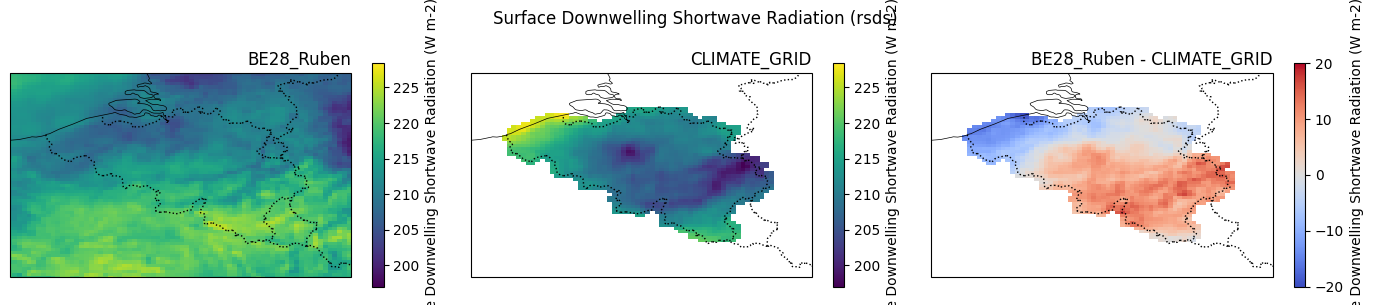

In [32]:
months_to_analyse = [6,7,8]




ds_mod = remap_cdo(gridfile, ds_mod, remap_method = "con")

# do spatial selection
ds_mod = select_region(ds_mod, region=region)
ds_obs = select_region(ds_obs, region=region)

# select variable and corresponding period
da_mod = ds_mod[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))
da_obs = ds_obs[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))


da_mod = da_mod.mean('time')
da_mod.attrs['dataset'] = experiment
da_obs = da_obs.mean('time')

if variable == 'pr': 
    da_mod = _convert_kg_m2s_to_mm_day(da_mod)
    da_obs = _convert_kg_m2s_to_mm_day(da_obs)

da_diff = da_mod - da_obs

ax = plot_maps_mod_ref_diff(da_mod,  da_obs,  da_diff, region=region)


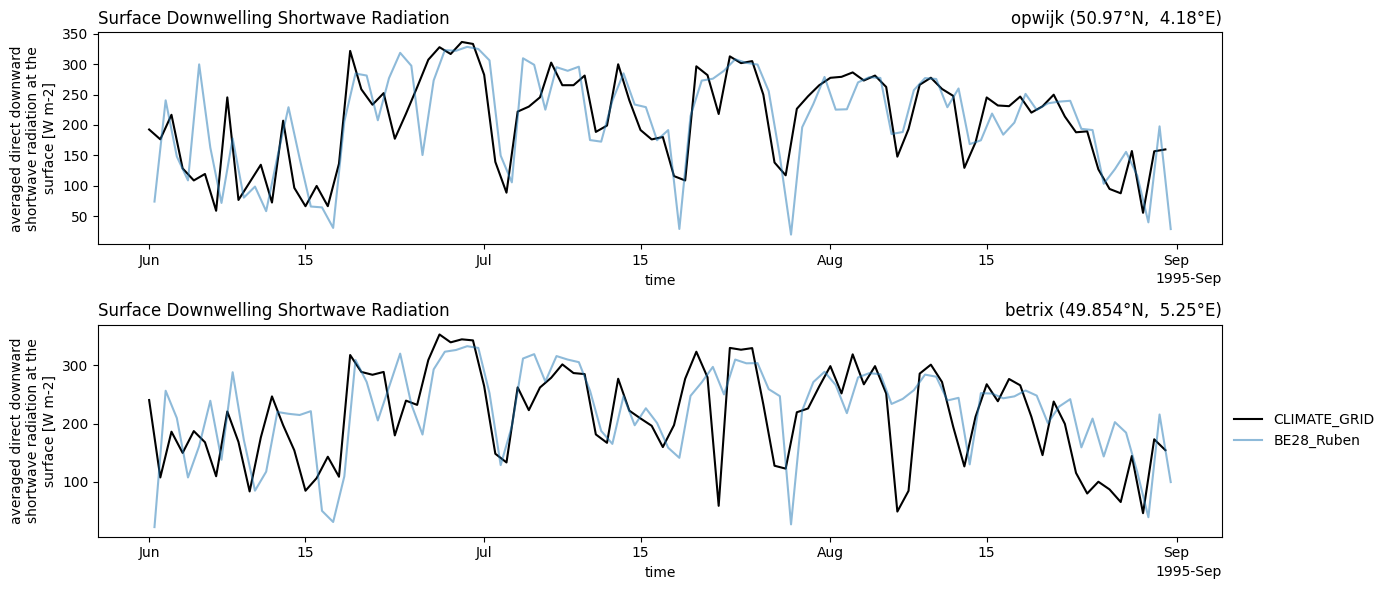

In [37]:
    fig, axes = plt.subplots(2,1,figsize = (14,6))
    axes = axes.flatten()

    for i,point_id in enumerate(d_point_coords): 
        ax = axes[i]
        point_coord = d_point_coords[point_id]
        ds_obs_point = select_point(ds_obs, point_coord)
        ds_mod_point = select_point(ds_mod, point_coord)
        da_mod_point = ds_mod_point[variable].sel(time=ds_mod_point['time'].dt.month.isin(months_to_analyse))
        da_obs_point = ds_obs_point[variable].sel(time=ds_obs_point['time'].dt.month.isin(months_to_analyse))

        # do plotting
        # when no ax element is passed, create the figure within the function

        da_obs_point.plot(ax=ax, label = ref_dataset, color='k')

        da_mod_point.plot(ax=ax, label = experiment, alpha=0.5)

        ax.set_title(' ', loc='center')
        ax.set_title(f"{point_id} ({point_coord[1]}°N,  {point_coord[0]}°E)", loc='right');
        ax.set_title(da_obs_point.attrs['long_name'], loc='left')


        if i == 1: 
            ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

    fig.tight_layout()
      


### Downwelling shortwave